In [2]:
import sys
import numpy as np
from scipy.spatial import cKDTree
import ghalton
import matplotlib.pyplot as plt
import time

In [4]:
%matplotlib inline

In [72]:
def generate_halton_sequence(npoints, seed, dims):
    sequencer = ghalton.GeneralizedHalton(dims, seed)
    return np.asarray(sequencer.get(npoints), dtype='float32')

def generate_numpy_uniform_sequence(npoints, seed, dims):
    random = np.random.RandomState(seed)
    return random.uniform(low=0., high=1, size=(npoints, dims))

def nearest_neighbor_analysis(npoints, seed, dims, genHalton=True):
    points = None
    if genHalton:
        points = generate_halton_sequence(npoints, seed, dims)
    else:
        points = generate_numpy_uniform_sequence(npoints, seed, dims)
    
    points = np.asarray([points[:,dims-2], points[:,dims-1]]).T
    tree = cKDTree(points)
    
    distances = []
    for n in xrange(points.shape[0]):
        d, _ = tree.query(points[n,:],2)
        distances.append(d[-1])
    return points, np.asarray(distances, dtype='float32')

def correlation_analysis(npoints, seeds, dims, genHalton=True):
    dims = np.arange(dims) + 1
    max_corr_lst = []
    for dim in dims:
        points_lst = []
        for seed in seeds:
            if genHalton:
                points_lst.append(generate_halton_sequence(npoints, int(seed), dim))
            else:
                points_lst.append(generate_numpy_uniform_sequence(npoints, int(seed), dim))
        points = np.asarray(points_lst)
        ccoef  = np.corrcoef(points[:,:,dim-1])
        ccoef_no_diagonal = np.abs(ccoef[~np.eye(ccoef.shape[0], dtype=bool)].reshape(ccoef.shape[0], -1))
        max_corr_lst.append(np.max(ccoef_no_diagonal))
    return max_corr_lst
                
    

In [71]:
def scatter_plot(x, x_labels, title, legendOn=True):
    plt.figure()
    for i in xrange(len(x)):
        plt.scatter(x[i][:,0], x[i][:,1], label=x_labels[i])
    if legendOn:
        plt.legend()
    plt.title(title)
 
def distances_plot(x, x_labels, title, legendOn=True):
    fig, axes = plt.subplots(2,1)
    for i in xrange(len(x)):
        if i == 0:
            hist, edges = np.histogram(x[i], bins=20)
        else:
            hist, _ = np.histogram(x[i], bins=edges)
        axes[0].plot(x[i], label=x_labels[i])
        axes[1].plot(edges[1:], hist, label=x_labels[i])
    if legendOn:
        axes[0].legend()
        axes[1].legend()
    axes[0].set_title(title)
    
def vanilla_plot(x, y, labels, title, logY=False):
    x = np.asarray(x)
    y = np.asarray(y)

    plt.figure()
    for i in xrange(y.shape[1]):
        plt.plot(x, y[:,i], label=labels[i])
    plt.legend()
    plt.title(title)
    
    if logY:
        plt.yscale('log')
    


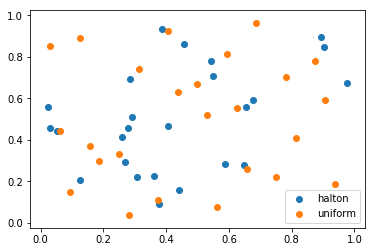

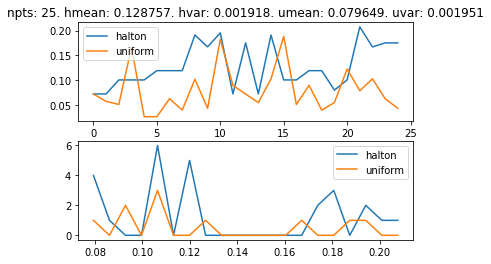

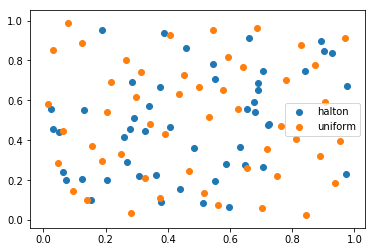

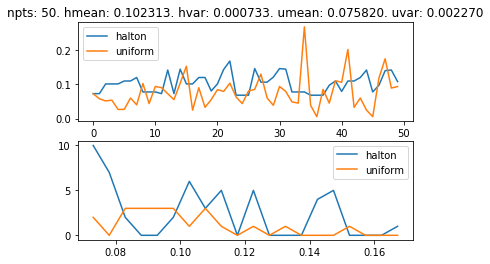

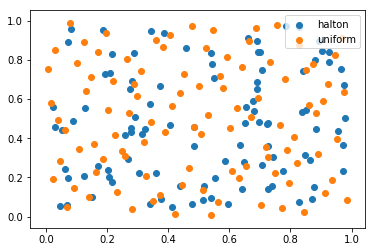

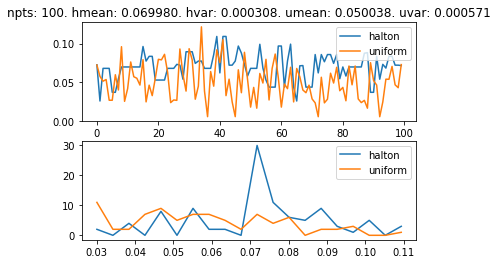

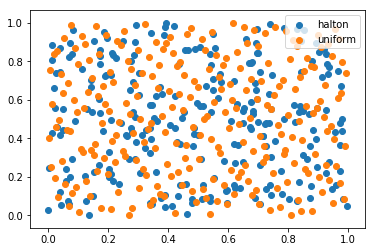

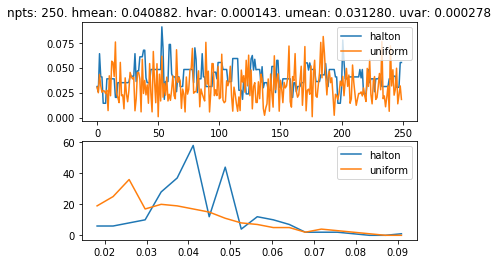

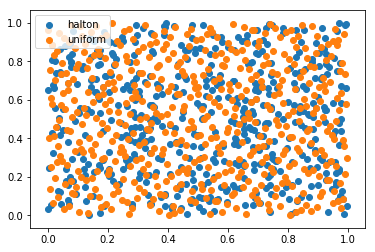

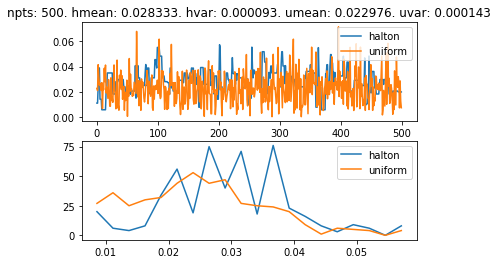

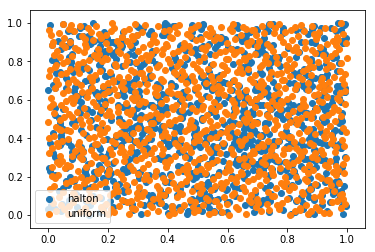

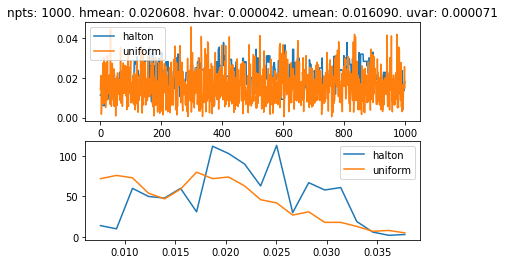

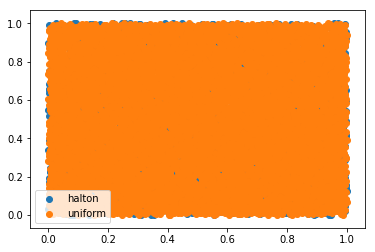

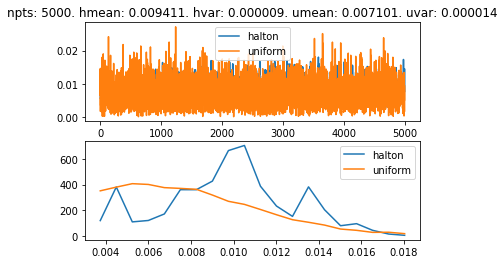

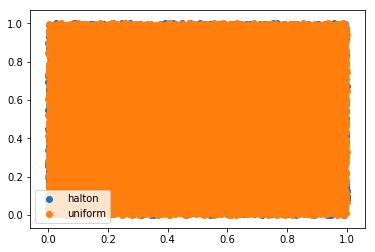

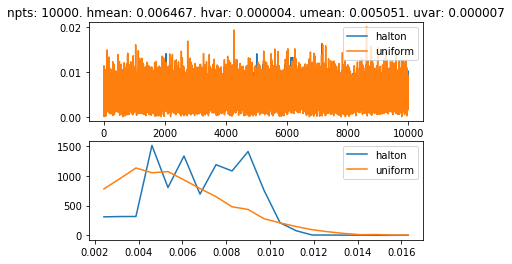

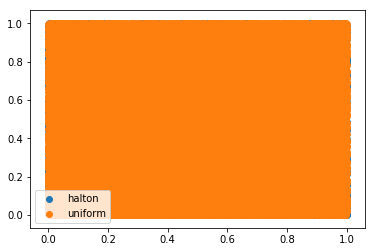

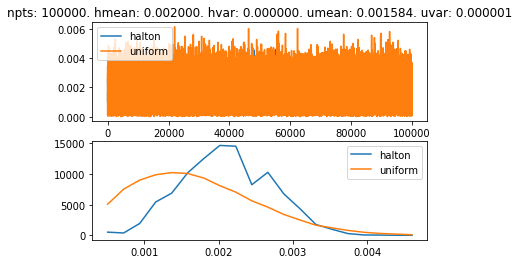

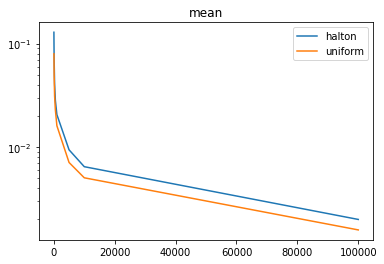

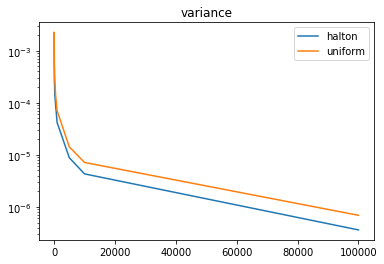

In [68]:
seed = 3
dims = 2

npts_lst = [25, 50, 100, 250, 500, 1000, 5000, 10000, 100000]
mean_stats  = []
var_stats = []
for npts in npts_lst:

    points_halton, distances_halton = nearest_neighbor_analysis(npts, seed, dims, genHalton=True)
    points_uniform, distances_uniform = nearest_neighbor_analysis(npts, seed, dims, genHalton=False)

    halton_mean  = np.mean(distances_halton)
    halton_var   = np.var(distances_halton)
    uniform_mean = np.mean(distances_uniform)
    uniform_var  = np.var(distances_uniform)
    
    mean_stats.append((halton_mean, uniform_mean))
    var_stats.append((halton_var, uniform_var))
           
    plot_title   = 'npts: %i. hmean: %f. hvar: %f. umean: %f. uvar: %f' % (npts, halton_mean, halton_var, uniform_mean, uniform_var)
    
    scatter_plot([points_uniform, points_halton], ['halton', 'uniform'], '')
    distances_plot([distances_halton, distances_uniform], ['halton', 'uniform'], plot_title)

vanilla_plot(npts_lst, mean_stats, ['halton', 'uniform'], 'mean', logY=True)
vanilla_plot(npts_lst, var_stats, ['halton', 'uniform'], 'variance', logY=True)




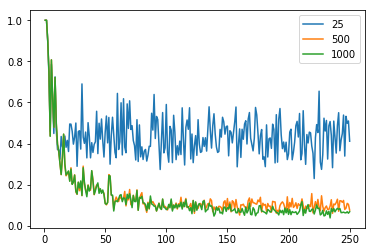

In [74]:
seeds   = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
npts_lst = [25, 500, 1000]
dims     = 250

max_lst = []
for npts in npts_lst:
    max_lst.append(correlation_analysis(npts, seeds, dims))
max_lst = np.asarray(max_lst, dtype='float32')

plt.figure()
for i in xrange(max_lst.shape[0]):
    plt.plot(np.arange(dims)+1, max_lst[i,:], label='%i' % (npts_lst[i]))
plt.legend()

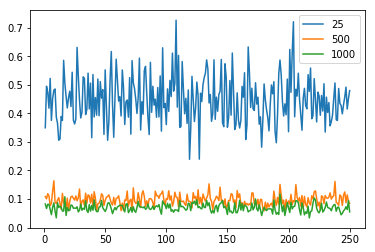

In [75]:
seeds   = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
npts_lst = [25, 500, 1000]
dims     = 250

max_lst = []
for npts in npts_lst:
    max_lst.append(correlation_analysis(npts, seeds, dims, genHalton=False))
max_lst = np.asarray(max_lst, dtype='float32')

plt.figure()
for i in xrange(max_lst.shape[0]):
    plt.plot(np.arange(dims)+1, max_lst[i,:], label='%i' % (npts_lst[i]))
plt.legend()